# RAG on Single Episode v0 MVP
__Author:__ Jack Friedman <br>
__Purpose:__ RAG pipeline on a single transcript with quantiative analysis

In [18]:
import os
import dotenv
from langchain_community.document_loaders import TextLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'YOUR_TOKEN_HERE'

### Step 0: Compare various chunking strategies

In [7]:
loader = TextLoader("sample_transcript.txt")
embeddings_model = HuggingFaceEmbeddings()

#### A) Semantic Chunker

In [8]:
# Semantic Chunker - Percentile
text_splitter = SemanticChunker(embeddings_model,
                                breakpoint_threshold_type="percentile")
docs_percentile = loader.load_and_split(text_splitter)
print(len(docs_percentile))

137


In [9]:
# Semantic Chunker - Standard Deviation
text_splitter = SemanticChunker(embeddings_model,
                                breakpoint_threshold_type="standard_deviation")

docs_stddev = loader.load_and_split(text_splitter)
print(len(docs_stddev))

37


In [10]:
# Semantic Chunker - Standard Deviation
text_splitter = SemanticChunker(embeddings_model,
                                breakpoint_threshold_type="interquartile")

docs_iqrt = loader.load_and_split(text_splitter)
print(len(docs_iqrt))

161


### Step 1: Quantitative Document analysis (number/length clips)

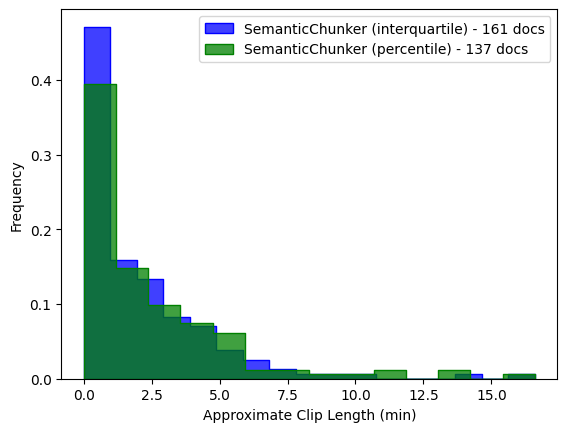

In [29]:
# Plot frequency of document length
WORDS_PER_MIN = 150
def get_length_distribution(docs):
    length = []
    for doc in docs:
        length += [len(doc.page_content.split()) / WORDS_PER_MIN]
    return length

length_percentile = get_length_distribution(docs_percentile)
length_stddev = get_length_distribution(docs_stddev)
length_iqrt = get_length_distribution(docs_iqrt)

sns.histplot(length_iqrt,color='blue', label='SemanticChunker (interquartile) - ' + str(len(length_iqrt)) + ' docs', element='step', stat="density")
sns.histplot(length_percentile, color='green', label='SemanticChunker (percentile) - ' + str(len(length_percentile)) + ' docs', element='step', stat="density")
# sns.histplot(length_stddev,  color='red', label='SemanticChunker (std dev) - ' + str(len(length_stddev)) + ' docs', element='step', stat="density")

plt.ylabel('Frequency')
plt.xlabel('Approximate Clip Length (min)')
plt.legend()
plt.show()


### Step 2: Qualitative Comparison

#### Step 2A: Examine documents

In [ ]:
# Percentile
for i in range(len(docs_percentile)):
    print()
    if i > 2:
        break

#### Step 2B: Examine Retriever

In [28]:
# Set up vector store and retriever
db = FAISS.from_documents(docs_percentile, embeddings_model)
retriever = db.as_retriever(search_kwargs={"k": 15})
retriever.get_relevant_documents("What does Marc Andreessen say about AI?")

[Document(page_content="So what he, what he said, and I'm sure this is true. What he said was to make these large language models work, we need a lot of computer capacity and we need a lot of data. And, and we're gonna need to, we need billions of dollars. Basically, he said, I know how to raise $100 million for, for nonprofits. I don't know how to raise $10 billion for nonprofits. It's just hard to do that.", metadata={'source': 'sample_transcript.txt'}),
 Document(page_content="Well, no. So it was a, it was, this was considered research, not development. And so the, the, the, the way that it was, it was like an internal scientific unit at a company. And so they actually published it as a paper. I see. And, and they're actually, there's a long history of this where this is actually a lot of the great breakthroughs over time have actually come out of like industrial research labs like this. And then they, and then the company that develops, it publishes it and then they don't realize u

[Document(page_content="So what he, what he said, and I'm sure this is true. What he said was to make these large language models work, we need a lot of computer capacity and we need a lot of data. And, and we're gonna need to, we need billions of dollars. Basically, he said, I know how to raise $100 million for, for nonprofits. I don't know how to raise $10 billion for nonprofits. It's just hard to do that.", metadata={'source': 'sample_transcript.txt'}),
 Document(page_content="Well, no. So it was a, it was, this was considered research, not development. And so the, the, the, the way that it was, it was like an internal scientific unit at a company. And so they actually published it as a paper. I see. And, and they're actually, there's a long history of this where this is actually a lot of the great breakthroughs over time have actually come out of like industrial research labs like this. And then they, and then the company that develops, it publishes it and then they don't realize u

### Step 3: Analyze document length 

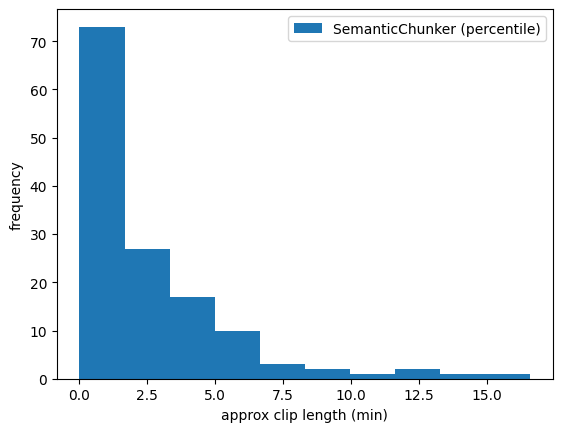